In [17]:
!pip install pandas==1.3.4

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-1.3.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.5 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuron import Neuron
import os

# Logs from calculations on the 1. subset

In [2]:
jobs = pickle.load(open("results_from_jobs.pkl", "rb"))
nohup = pickle.load(open("results_from_nohup.pkl", "rb"))
manual_labels = pd.read_csv("cell_types.csv")
columns = ["id1", "id2", "distance", "runtime"]
jobs.columns = columns
nohup.columns = columns
assigned_calcs_jobs = jobs.loc[jobs["id1"] != -1]
assigned_calcs_nohup = nohup.loc[nohup["id1"] != -1]

In [3]:
all_calcs = pd.merge(jobs, nohup, how="outer", on=columns)
all_calcs

id1                 id2  distance     runtime
0     864691136286806979  864691136286841795  263.9632  84678.7451
1                     -1                  -1  273.4906   1775.8664
2                     -1                  -1   91.4202    257.9327
3                     -1                  -1    0.0000    249.5654
4                     -1                  -1  109.4964    336.3787
...                  ...                 ...       ...         ...
7892  864691134885183738  864691135740508267  128.7890    147.5145
7893  864691134885183738  864691135758647630  177.3630    246.7074
7894  864691134885183738  864691135776103853  102.6839    154.6266
7895  864691134885183738  864691135776547936   89.2161    243.7825
7896  864691134885183738  864691135781098064  103.0499    153.3663

[7897 rows x 4 columns]

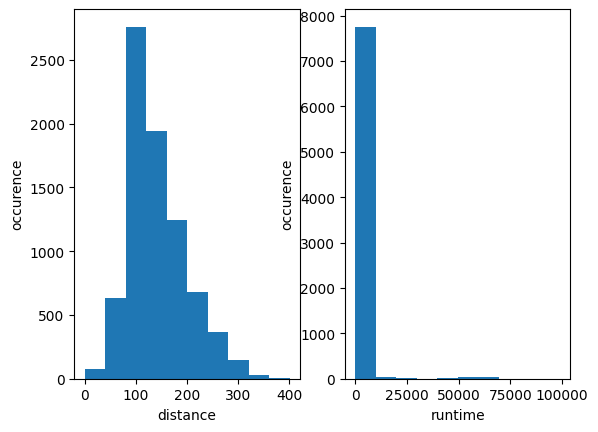

In [4]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(all_calcs["distance"])
axes[1].hist(all_calcs["runtime"])
axes[0].set_xlabel("distance")
axes[0].set_ylabel("occurence")
axes[1].set_xlabel("runtime")
axes[1].set_ylabel("occurence")
plt.show()

### Some Stats!

In [5]:
all_calcs[columns[2:]].describe()

distance       runtime
count  7897.000000   7897.000000
mean    140.641270   1269.338337
std      57.299601   6577.540849
min       0.000000      7.878900
25%      96.383300     82.495800
50%     129.817300    198.174500
75%     174.492200    459.824700
max     400.271700  99065.512400

# Logs from the all other subsets

In [6]:
logs = pickle.load(open("results_from_logs.pkl", "rb"))
logs.columns = columns
logs

id1                 id2  distance   runtime
0     864691135134667801  864691135345554335  317.0383  254.4806
1     864691135256626095  864691135440779848   64.7029   20.5186
2     864691135155873636  864691135213019520  190.2605  158.1510
3     864691135474930752  864691135490445415       inf       inf
4     864691135182131970  864691135544640808   85.5804   53.9984
...                  ...                 ...       ...       ...
3804  864691135687213280  864691135715263770  161.5361  128.6665
3805  864691135386843521  864691135639322427       inf       inf
3806  864691135564977239  864691135771828043       inf       inf
3807  864691134917686282  864691135683637746  134.0279   28.3675
3808  864691135065297220  864691135737841521       inf       inf

[3809 rows x 4 columns]

In [7]:
finished_logs = logs.loc[np.isfinite(logs["distance"])]
finished_logs[columns[2:]].describe()

distance      runtime
count  2388.000000  2388.000000
mean    141.656726   108.926368
std      55.430036    97.951947
min      47.462400    10.358700
25%      94.493450    40.760875
50%     134.597600    77.559000
75%     175.203200   137.184100
max     437.749400   591.335700

In [8]:
def drawneuron(id, ax):
    drawneuronswc(f"../datasets/IARPA/swc/{id}.swc", ax)

def drawneuronswc(swc_path, ax):
    neuron = Neuron()
    neuron.load_eswc(swc_path)
    
    if len(neuron.roots) > 1:
        print(f"Warning: {swc_path} has multiple roots, use the first 1 as center")
    center = np.array(neuron.vertices[neuron.roots[0]].coord)

    coords = np.ndarray((len(neuron.vertices), 3))
    for i, v in enumerate(neuron.vertices):
        coords[i, :] = v.coord - center

    ax.scatter(coords[:,0], coords[:,1], coords[:,2], edgecolors='None', marker='.')
    ax.set_xlabel("μm")
    ax.set_ylabel("μm")
    ax.set_zlabel("μm")

def load_calc(n, neuron_swc_folder):
    return load_distances_and_match_with_ids(f"all_distances_{n}.csv", f"all_run_times_{n}.csv", neuron_swc_folder)

def load_distances_and_match_with_ids(csv_distance_file, csv_run_time_file, neuron_swc_folder, shortened_recursions=None):
    ssa_distances = pd.read_csv(csv_distance_file, header=None).values
    ssa_run_times = pd.read_csv(csv_run_time_file, header=None).values
    ssa_recursion_depth = pd.read_csv(shortened_recursions, header=None).values if shortened_recursions else np.zeros(ssa_distances.shape)
    ids = list(map(lambda x: x.split(".")[0], os.listdir(neuron_swc_folder)))
    ids.sort()
    size = len(ids) ** 2
    id_1 = np.ndarray(size, dtype=np.int64)
    id_2 = np.ndarray(size, dtype=np.int64)
    distances = np.ndarray(size, dtype=np.float64)
    run_times = np.ndarray(size, dtype=np.float64)
    recursion_depth = np.ndarray(size, dtype=int)
    if len(ids) != ssa_distances.shape[0]:
        print("Lengths do not match!")
    for i in range(len(ids)):
        ssa_distances[i, i] = 0
        for j in range(len(ids)):
            idx = i * len(ids) + j
            id_1[idx] = ids[i]
            id_2[idx] = ids[j]
            if i == j:
                distances[idx] = 0
                run_times[idx] = 0
                recursion_depth[idx] = 3
            else:
                distances[idx] = ssa_distances[i, j]
                run_times[idx] = ssa_run_times[i, j]
                recursion_depth[idx] = 2 if ssa_recursion_depth[i, j] > 0 else 3
    
    if shortened_recursions:
        return ssa_distances, pd.DataFrame(data={"id1": id_1, "id2": id_2, "distance": distances, "runtime": run_times, "recursion_depth": recursion_depth})
    else:
        return ssa_distances, pd.DataFrame(data={"id1": id_1, "id2": id_2, "distance": distances, "runtime": run_times})

swc_dir = "../datasets/IARPA/swc/subsetEvenSplit"
all_logs = []
for i in range(7):
    all_logs.append(load_calc(i+2, swc_dir)[1])

In [9]:
all_logs[1][columns[2:]].describe()

distance       runtime
count  21609.000000  21609.000000
mean     194.635313    637.199079
std       92.385454    935.873986
min        0.000000      0.000000
25%      125.236760     54.905573
50%      178.202196    184.881827
75%      242.219737    960.257019
max      531.366674  31422.102720

### Which calculations didn't finish / needed a lot of time?

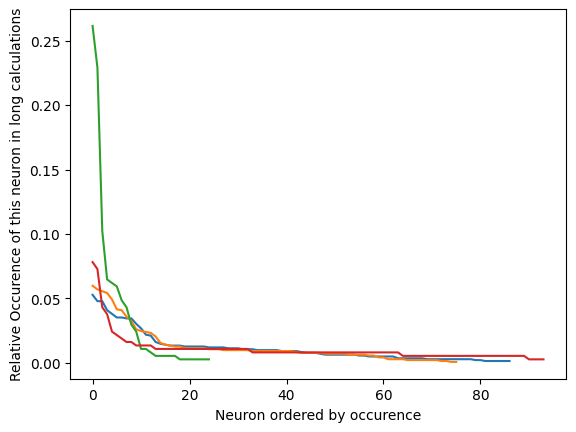

In [11]:
long_logs = logs.loc[np.logical_not(np.isfinite(logs["runtime"]))]
long_jobs = all_calcs.loc[all_calcs["runtime"] > 600]

def responsible_neurons(neurons):
    value_counts = neurons.value_counts()
    unknownNeuron = -1.
    if unknownNeuron in value_counts.index:
        value_counts.drop(labels=unknownNeuron, inplace=True)
    return value_counts
    
def plot_responsible_neurons(value_counts):
    value_counts = value_counts.copy()
    value_counts.index = range(len(value_counts))
    plt.plot(value_counts / sum(value_counts))

n1 = responsible_neurons(long_logs["id1"])
n2 = responsible_neurons(long_logs["id2"])
n3 = responsible_neurons(long_jobs["id1"])
n4 = responsible_neurons(long_jobs["id2"])
plot_responsible_neurons(n1)
plot_responsible_neurons(n2)
plot_responsible_neurons(n3)
plot_responsible_neurons(n4)

plt.xlabel("Neuron ordered by occurence")
plt.ylabel("Relative Occurence of this neuron in long calculations")
plt.show()

Does the long computation time depend on the neuron or the matching? Above graph shows that a selection of only a few neurons tend to reappear in high-demanding calculations making it likely these single neurons are responsible. Let's have a look at them: 

In [12]:
fig = plt.figure() 
    
fig, axes = plt.subplots(4, 2, figsize=(15, 9), subplot_kw={"projection": "3d"})
fig.set_figheight(18)
fig.set_figwidth(18)

def avg_comp_time(neuron_id):
    

# The neurons slowing computation the most
drawneuron(n1.index[0], axes[0,0])
drawneuron(n2.index[0], axes[1,0])
drawneuron(n3.index[0], axes[2,0])
drawneuron(n4.index[0], axes[3,0])

# The neurons slowing computation the least
idx_fastest_neurons = np.argpartition(all_calcs["runtime"], 4)[:4]
fastest_calcs = all_calcs.iloc[idx_fastest_neurons]
fastest_neurons = list(set(fastest_calcs["id1"]) | set(fastest_calcs["id2"]))
drawneuron(fastest_neurons[0], axes[0,1])
drawneuron(fastest_neurons[1], axes[1,1])
drawneuron(fastest_neurons[2], axes[2,1])
drawneuron(fastest_neurons[3], axes[3,1])
axes[0,1].set_title("Test")
plt.show()

IndentationError: expected an indented block after function definition on line 7 (401567989.py, line 11)

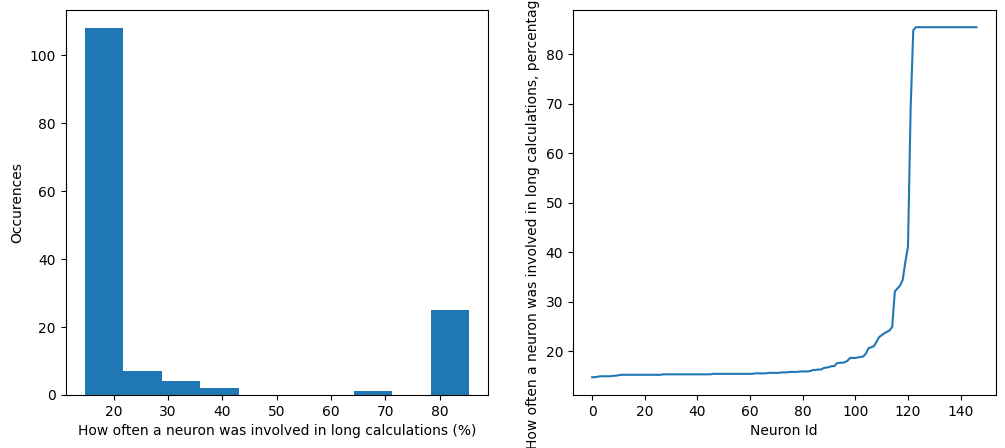

In [13]:
def perc_long_calcs_of_neuron_in_log(neuron_id, logs):
    involved_calcs = np.logical_or(logs["id1"] == neuron, logs["id2"] == neuron)
    involved_long_calcs = np.logical_and(np.logical_or(logs["id1"] == neuron, logs["id2"] == neuron), logs["runtime"] > 600)
    n_involved_calcs = np.count_nonzero(involved_calcs)
    n_long_calcs = np.count_nonzero(involved_long_calcs)
    return n_long_calcs / n_involved_calcs

neuron_ids = pd.unique(all_logs[1]["id2"])
perc_long_calcs = np.zeros(len(neuron_ids))
for i, neuron in enumerate(neuron_ids):
    for log in all_logs[1:]:
        perc_long_calcs[i] += perc_long_calcs_of_neuron_in_log(neuron, log) / len(all_logs) * 100
    
p_long_calcs = list(perc_long_calcs)
p_long_calcs.sort()
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].hist(perc_long_calcs)
axes[0].set_xlabel("How often a neuron was involved in long calculations (%)")
axes[0].set_ylabel("Occurences")
axes[1].plot(p_long_calcs)
axes[1].set_xlabel("Neuron Id")
axes[1].set_ylabel("How often a neuron was involved in long calculations, percentage wise")
plt.savefig("figures/perc_involved_neurons.png")
plt.show()

Of which class are the neurons that always take long to compare with other neurons ("perpetrators")?

In [24]:
amount_perpetrators = np.count_nonzero(perc_long_calcs > 80)
partition = np.argpartition(perc_long_calcs, -amount_perpetrators)
indices_perpetrators = partition[-amount_perpetrators:]
indices_fastest = partition[:amount_perpetrators]
ids_perpetrators = neuron_ids[indices_perpetrators]
ids_fastest = neuron_ids[indices_fastest]

def type_of(neuron_id):
    clazz = manual_labels[manual_labels["pt_root_id"] == neuron_id]["cell_type_manual"]
    if not clazz.empty:
        return clazz.item()
    else:
        return None
    
def avg_comp_time(neuron):
    means = []
    for log in all_logs[1:]:
        means.append(np.median(log[np.logical_or(log["id1"] == neuron, log["id2"] == neuron)]["runtime"]))
    return np.mean(means)
    
print(len(ids_perpetrators))
print([type_of(id) for id in ids_perpetrators])

25
['Unsure I', 'BC', 'MC', 'MC', 'Unsure I', 'MC', 'MC', 'Unsure I', 'BC', 'Unsure I', 'BC', 'BC', 'NGC', 'BC', 'NGC', 'BC', 'NGC', 'MC', 'NGC', 'MC', 'BC', 'MC', 'MC', 'NGC', 'BC']


No single cell type stands out. Lets look at them directly: 

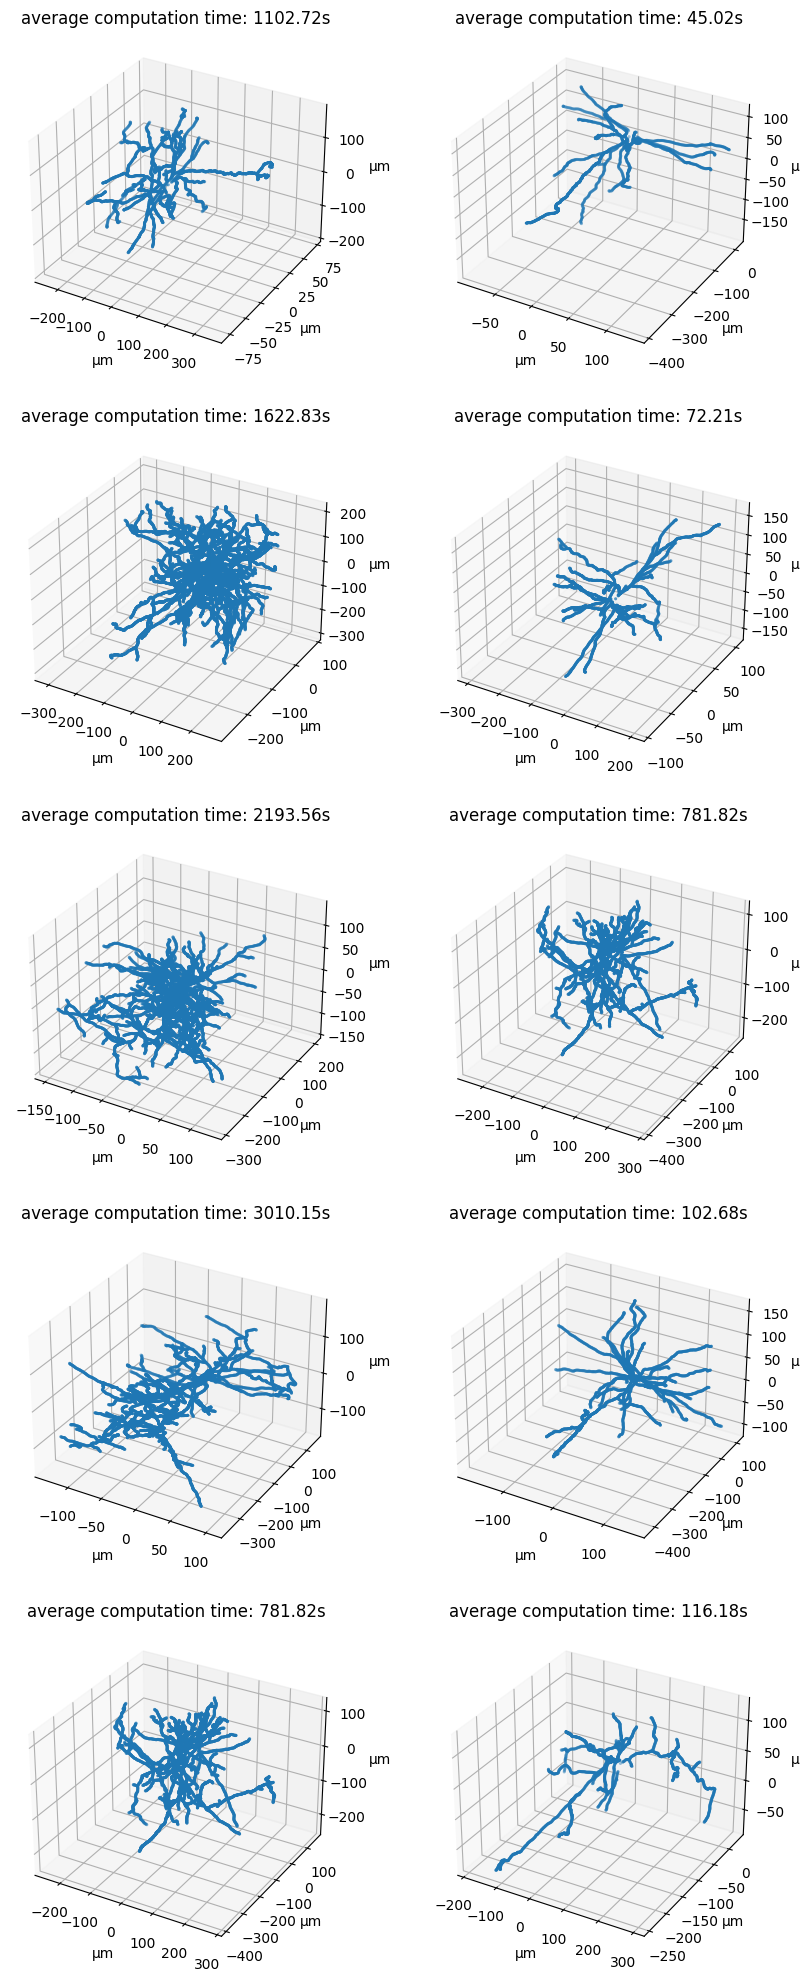

In [25]:
dim = (5, 2)
fig, axes = plt.subplots(dim[0], dim[1], figsize=(10, 25), subplot_kw={"projection": "3d"})

idx_fastest_neurons = np.argpartition(all_logs[1]["runtime"], 25)[:25]
fastest_calcs = all_logs[1].iloc[idx_fastest_neurons]
fastest_neurons = list(set(fastest_calcs["id1"]) | set(fastest_calcs["id2"]))

for i, neuron_id in enumerate(ids_perpetrators[:dim[0]]):
    drawneuron(neuron_id, axes[i, 0])
    axes[i, 0].set_title(f"average computation time: {avg_comp_time(neuron_id):.2f}s")
    drawneuron(fastest_neurons[i], axes[i, 1])
    axes[i, 1].set_title(f"average computation time: {avg_comp_time(fastest_neurons[i]):.2f}s")
    
plt.savefig("culprits.png")
plt.show()

In [17]:
for id in fastest_neurons:
    print(avg_comp_time(id))

370.4183846894198
360.79629456427756
971.9296488316268
405.34168805460746
416.7476038862344
402.48128860978386
433.18178028782705
354.2623882514221
2504.0258075699658
353.3662574505119
354.51540645620025
385.3384527974972
387.8029502980659
434.30263874175193
338.9854666268487
2338.9197653777023
367.90460143799777
512.6308288304891
414.88230513879404
1939.0097585437998
369.1238218339022
2621.84228801934
341.7089306279863
556.6490301899886
353.4691544527873
